In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
# Need to be added before import of tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
sys.path.append("../")
import src.mp.MomentPropagation as mp
import numpy as np
import pandas as pd
import urllib.request
import time
from scipy import stats
from tqdm.notebook import tqdm as tqdm
%matplotlib inline
plt.style.use('default')

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
tfk = tf.keras

1 Physical GPUs, 1 Logical GPUs


# Plot functions
Some plot functions to visualize the dataset predictions

In [2]:
def vertical_line_training_range(X_train,ax):
    minx, maxx = np.min(X_train), np.max(X_train)
    ax.axvline(maxx,c="red",ls="--")
    ax.axvline(minx,c="red",ls="--")#, label=u'$[D_{Train}]$')
    
def plot_dataset(X_train, y_train, X_test,y_test):
    plt.figure(figsize=(20,3))
    plt.scatter(X_train.flatten(),y_train.flatten(),s=0.5)
    plt.scatter(X_test.flatten(),y_test.flatten(),s=0.5)
    plt.xlabel("x_train")
    plt.ylabel("y_train")
    plt.title("The x values of the synthetic data ranges between {:4.3f} and {:4.3f}".format(
        np.min(X_train),np.max(X_train)))
    vertical_line_training_range(X_train, plt.gca())
    plt.show()
    
def plot_predictive_distribution(x_train, y_train,
                                 x_test, y_test,
                                 y_pred, y_pred_std,
                                 rmse = None,
                                 nll = None,
                                 rt = None,
                                 plot_ground_truth=False,
                                 title="", ax=None):

    # plot predictive distribution
    if ax is None:
        fig = plt.figure(figsize=(20, 8))
        ax = fig.add_subplot(111)
        ax.set_title(title)
    else:
        ax.set_title(title,fontsize=16,fontweight='bold')
        
    vertical_line_training_range(x_train, ax)
    
    ax.plot(x_test, y_pred, 'b-', linewidth=2.,label=u'Prediction')

    ax.plot(x_test, y_pred + 1.96 * y_pred_std, 'b', linewidth=0.5)
    ax.plot(x_test, y_pred - 1.96 * y_pred_std, 'b', linewidth=0.5)
    ax.plot(x_test, y_pred + 1 * y_pred_std, 'b', linewidth=0.5)
    ax.plot(x_test, y_pred - 1 * y_pred_std, 'b', linewidth=0.5)

    ax.fill(np.concatenate([x_test, x_test[::-1]]),
             np.concatenate([y_pred - 1.96 * y_pred_std,
                            (y_pred + 1.96 * y_pred_std)[::-1]]),
             alpha=1, fc='lightskyblue', ec='None',label=r'$\pm 2\sigma$')

    ax.fill(np.concatenate([x_test, x_test[::-1]]),
             np.concatenate([y_pred - 1 * y_pred_std,
                            (y_pred + 1 * y_pred_std)[::-1]]),
             alpha=1, fc='deepskyblue', ec='None',label=r'$\pm 1\sigma$')

    ax.plot(x_train[:,0], y_train, 'r.', markersize=8,
            markeredgecolor='k',markeredgewidth=0.5, label=u'Training Data')
    
    if plot_ground_truth:    
        ax.plot(x_test[:,0], y_test, 'g-', markersize=8,
            markeredgecolor='g',markeredgewidth=0.5, label=u'Ground Truth')
    
    #ax.set_ylim(min(y_train)-np.std(y_train), max(y_train)+np.std(y_train))
    #ax.set_xlim(min(x_test)-np.std(x_test), max(x_test)+np.std(x_test))
    if rmse is not None:
        ax.plot([], label=f'rmse:{rmse:.5}')

    if nll is not None:
        ax.plot([], label=f'nll:{nll:.5}')
        
    if rt is not None:
        ax.plot([], label=f'rt:{rt:.5}')
        
    ax.legend()
    
    
def plot_predictive_distribution_combined(x_train, y_train, 
                                         x_test, y_test,
                                         y_pred_mc, y_pred_std_mc,
                                         y_pred_mp, y_pred_std_mp, 
                                         plot_ground_truth=False,
                                         plot_training_data=False,
                                         plot_legend=True,
                                         title="",ax=None, mode=[1,2]):

    # plot predictive distribution
    if ax is None:
        fig = plt.figure(figsize=(20, 8))
        ax = fig.add_subplot(111)
        ax.set_title(title)
    else:
        ax.set_title(title,fontsize=16,fontweight='bold')
        
    vertical_line_training_range(x_train, ax)    
    
    mc_unc = 1.96 * y_pred_std_mc
    mp_unc = 1.96 * y_pred_std_mp
    
    if 1 in mode:
        ax.plot(x_test, y_pred_mc, 'b-', linewidth=3.,label=u'$E^{MC}_{\mu}$')
        ax.plot(x_test, y_pred_mc + mc_unc, color='deepskyblue',linewidth=4.5)
        ax.plot(x_test, y_pred_mc - mc_unc, color='deepskyblue',linewidth=4.5)
        ax.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_pred_mc - mc_unc,
                        (y_pred_mc + mc_unc)[::-1]]),
         alpha=1., fc='lightskyblue', ec='None',label=r'$E^{MC}_{\mu}\pm 2\sqrt{V^{MC}_{\mu}}$')
    if 2 in mode:
        ax.plot(x_test, y_pred_mp, 'r-', linewidth=3.,linestyle='dashed',label=u'$E^{MP}_{\mu}$')
        ax.plot(x_test, y_pred_mp + mp_unc, color='indianred', linestyle='dashed',linewidth=4.5)
        ax.plot(x_test, y_pred_mp - mp_unc, color='indianred', linestyle='dashed',linewidth=4.5)     
        ax.fill(np.concatenate([x_test, x_test[::-1]]),
             np.concatenate([y_pred_mp - mp_unc,
                            (y_pred_mp + mp_unc)[::-1]]),
             alpha=1., fc='lightcoral', ec='None',label=r'$E^{MP}_{\mu}\pm 2\sqrt{V^{MP}_{\mu}}$')
    
#     ax.errorbar(x_test, y_pred_mc, yerr=y_pred_std_mc, capsize=0,label=r'MC$\pm 2\sigma$')
#     ax.errorbar(x_test, y_pred_mp, yerr=y_pred_std_mp, capsize=0,label=r'EP$\pm 2\sigma$')
    
    if plot_training_data:
        ax.plot(x_train[:,0], y_train, 'k.', markersize=4,
                markeredgecolor='k',markeredgewidth=0.5, alpha=0.3,label=u'$D_{Train}$')
    
    if plot_ground_truth:    
        ax.plot(x_test[:,0], y_test, 'k-', markersize=4,
            markeredgecolor='k',markeredgewidth=0.5, alpha=0.3, label=u'Ground Truth')
    
    ax.set_xlabel('x',fontsize=32)
    ax.set_ylabel('y',fontsize=32)
    ax.tick_params(axis='both', which='major', labelsize=16)
    if plot_legend:
        ax.legend(handlelength=3,prop={'size': 22})
    


def plot_predictions_combined(
                              x_train, y_train, 
                              x_test, y_test,
                              mu_normal,
                              mu_mc,
                              mu_mp,
                              mu_ep=None,
                              plot_ground_truth=False,
                              plot_training_data=False,
                              plot_legend=True,
                              title="", ax=None, mode=[1,2,3]):

    # plot predictive distribution
    if ax is None:
        fig = plt.figure(figsize=(20, 8))
        ax = fig.add_subplot(111)
        ax.set_title(title)
    else:
        ax.set_title(title,fontsize=16,fontweight='bold')
    
    vertical_line_training_range(x_train, ax)
    
    if 1 in mode:
        ax.plot(x_test, mu_normal, 'k-', linewidth=3.,label=u'$E_{\mu}$')
    if 2 in mode:
        ax.plot(x_test, mu_mc, 'b-', linewidth=3., label=u'$E^{MC}_{\mu}$')
    if 3 in mode:
        ax.plot(x_test, mu_mp, 'r-', linewidth=3., linestyle='dashed', label=u'$E^{MP}_{\mu}$')
    if mu_ep is not None:
        ax.plot(x_test, mu_ep, 'y-', linewidth=3., label=u'$E^{MP-Approx}_{\mu}$')

    if plot_training_data:
        ax.plot(x_train[:,0], y_train, 'k.', markersize=4,
                markeredgecolor='k',markeredgewidth=0.5, alpha=0.3,label=u'$D_{Train}$')
    
    if plot_ground_truth:    
        ax.plot(x_test[:,0], y_test, 'k-', markersize=4,
            markeredgecolor='k',markeredgewidth=0.5, alpha=0.3, label=u'Ground Truth')
    
    #ax.set_ylim(min(y_train)-np.std(y_train), max(y_train)+np.std(y_train))
    #ax.set_xlim(min(x_test)-np.std(x_test), max(x_test)+np.std(x_test)) 
    ax.set_xlabel('x',fontsize=32)
    ax.set_ylabel('y',fontsize=32)
    ax.tick_params(axis='both', which='major', labelsize=16)
    if plot_legend:
        ax.legend(handlelength=3,prop={'size': 22})

# Create Dataset
We creating some datasets for training and validation (testing).

In [3]:
def sinusoid_1(n_train=512,n_test=512,noise=.1):
    np.random.seed(32)
    sigma = np.random.normal(0,noise,n_train)
    x = np.linspace(0,1*2*np.pi,n_train)
    y1 = 3*np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1+sigma))
    x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n_train)))
    print(min(x))
    print(max(x))
    y2 = 0.1*x+1
    y=y1+y2
      
    X_train = np.atleast_2d(x).T
    y_train = np.atleast_2d(y).T
        
    # Define Testdata
    pi_multi = 2.3
    x = np.linspace(0,1*pi_multi*np.pi,n_test)
    y1 = 3*np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1))
    x=np.concatenate((np.linspace(-10,0,60),np.linspace(0,3*pi_multi*np.pi,n_test)))
    y2 = 0.1*x+1
    y=y1+y2
      
    X_test = np.atleast_2d(x).T
    y_test= np.atleast_2d(y).T
    
    return [X_train, y_train, X_test,y_test]


def sinusoid_2(xmin=-10., xmax=10,  N=512, noise=.1):

    # Create the noise training data
    X_train = np.atleast_2d(np.linspace(xmin, xmax, N, dtype=np.float32)).T
    y_train = np.sin(X_train) + np.atleast_2d(np.random.normal(0, noise, size=N).astype(np.float32)).T

    # Create the testing data
    X_test = np.atleast_2d(np.linspace(xmin-2, xmax+2, N, dtype=np.float32)).T
    y_test = np.sin(X_test)
        
    return [X_train, y_train, X_test, y_test]



# Example from: https://fairyonice.github.io/Measure-the-uncertainty-in-deep-learning-models-using-dropout.html
def sinusoid_3(noise=.1):
    ## Define x
    inc = 0.001
    x_train =np.concatenate([np.arange(-2,-1.5,inc),np.arange(-1,0.5,inc)])
    x_train = x_train.reshape(len(x_train),1)

    ## Define y 
    steps_per_cycle = 1
    def sinfun(xs,noise=0):
        xs = xs.flatten()
        def randomNoise(x):
            wnoise = np.random.uniform(-noise, noise)
            return(np.sin(x * (2 * np.pi / steps_per_cycle) ) + wnoise)
        vec = [randomNoise(x) - x  for x in xs]
        return(np.array(vec).flatten())

    y_train0 = sinfun(x_train,noise) 
    y_train = y_train0.reshape(len(y_train0),1)

    maxx = np.max(x_train)
    x_test = np.arange(-2,0.8 ,inc).reshape(-1,1)
    y_test = sinfun(x_test)
    print(" x_train.shape={}".format(x_train.shape))
    print(" y_train.shape={}".format(y_train.shape))

    print("x_train -- Min:{:4.3f} Max:{:4.3f}".format(np.min(x_train),maxx))
    print("x_test  -- Min:{:4.3f} Max:{:4.3f}".format(np.min(x_test),np.max(x_test)))

    return [x_train,y_train,x_test,y_test]
    
datasets = [sinusoid_1,sinusoid_2,sinusoid_3]

## Plot the different datasets for evaluation
We want to plot the datasets with default values just for evaluation

-3.0
18.84955592153876


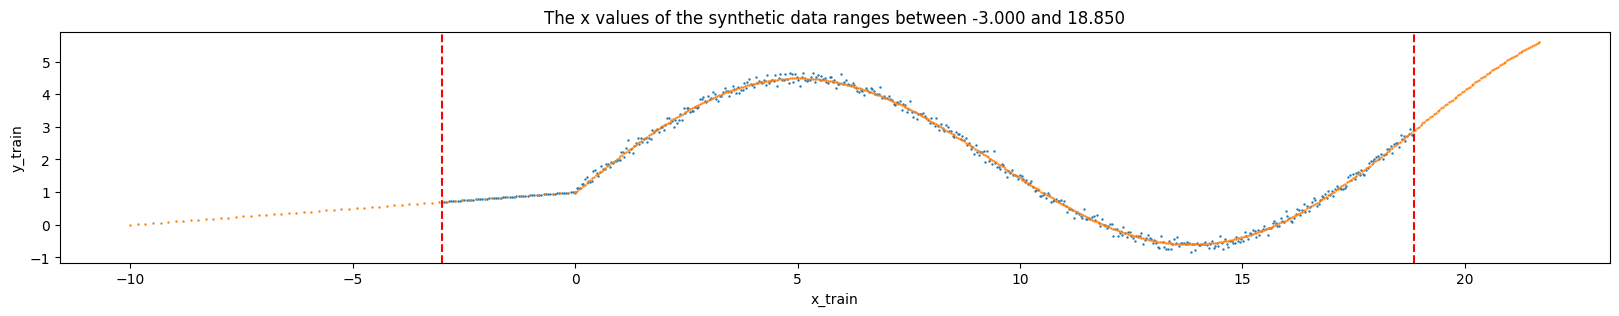

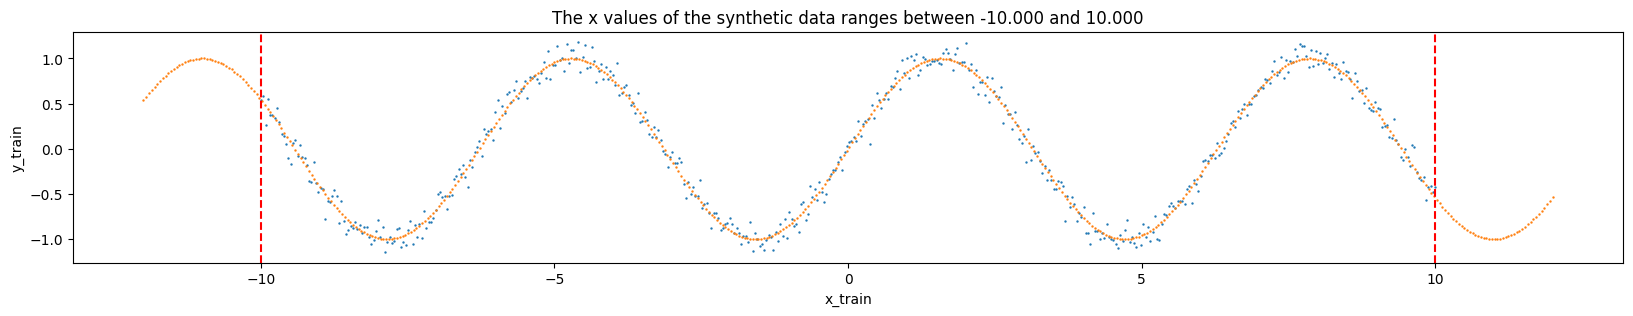

 x_train.shape=(2000, 1)
 y_train.shape=(2000, 1)
x_train -- Min:-2.000 Max:0.499
x_test  -- Min:-2.000 Max:0.799


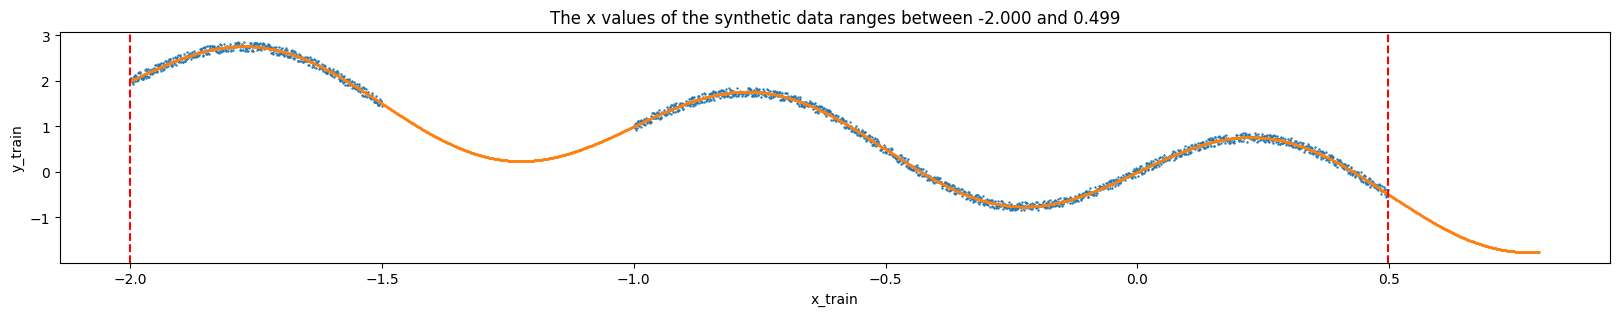

In [4]:
for d in datasets:
    X_train, y_train, X_test,y_test = d()
    plot_dataset(X_train, y_train, X_test,y_test)   

# Create Fully Connected Dropout Model with Error Propagation

We create a fully connected model (FC) with dropout layers. Supported activation functions are, Linear, ReLU. Further we create prediction functions for doing `MC dropout` and `Moment Propagation`.

The class contains the following functions:
* train:  Train the neural network
* predict: Normal prediction without uncertainty information
* predict_mc: MonteCarlo Dropout prediction (mean, variance)
* predict_mp: Prediction of the Moment Propagation model (mean, variance)
* model: Getter/Setter property for the trained model

Predictive Runtime, Root Mean Square Error, Negative Log Likelihood and Standard Deviation is calculated (if possible) for all predictions mentioned above.

## Moment Propagation

Inside of `predict_mp` function an Moment Propagation (MP) object is created. The `MP` class is designed for doing moment propagation or error propagation (`use_mp=False`) based on a given trained input model (with Dropout).


In [5]:
l2 = tfk.regularizers.l2
Input = tfk.layers.Input
Dropout = tfk.layers.Dropout
Dense = tfk.layers.Dense
Activation = tfk.layers.Activation
Model = tfk.models.Model
Adam = tfk.optimizers.Adam
SGD = tfk.optimizers.SGD

In [6]:
class net:

    def __init__(self, X_train, y_train, n_hidden, activation_fct='relu',
                 dropout = 0.1, normalize = True, summary=False):

        """
            Class constructor implementing a fully connected Tensorflow functional regression model for 
            predicting simple regression datasets with MC dropout and Moment Progagation method.
                                    
            @param X_train      Vector with training data for the inputs (N,1).
            @param y_train      Vector with training data for the targets (N,1).
            @param n_hidden     Vector with the number of neurons for each hidden layer.
            @param dropout      Dropout rate for all the dropout layers in the network.
            @param normalize    Set true if normalization is required for the input data.
            @param summary      Whether to print the model summary (layers) or not.
        """

        self.trained = False
        self._mp = mp.MP()
        self._mc_means = None
        
        # We normalize the training data to have zero mean and unit standard
        # deviation in the training set if necessary

        if normalize:
            self._std_X_train = np.std(X_train, 0)
            self._std_X_train[self._std_X_train == 0] = 1.
            self._mean_X_train = np.mean(X_train, 0)
            
            self._std_y_train = np.std(y_train)
            self._mean_y_train = np.mean(y_train)
        else:
            self._std_X_train = np.ones(X_train.shape[ 1])
            self._mean_X_train = np.zeros(X_train.shape[ 1])
            self._std_y_train = 1.
            self._mean_y_train = 0

            
        ''' Normalize the input data based on mean and std'''   
        self._X_train = self.normalize(X_train, self._mean_X_train, self._std_X_train)
        self._y_train = self.normalize(y_train, self._mean_y_train, self._std_y_train)
    

        ''' create the input tensor'''
        inputs = Input(shape=(self._X_train.shape[1],), name='input')
       
        #x = Dropout(rate=dropout)(inputs) # We do not recommend using dropout on the input, 
                                           # because it leads to information loss (feel free to test it)
        x = Dense(n_hidden[0], activation=activation_fct,kernel_initializer="normal")(inputs)

        ''' Create hidden layers'''
        for i in range(len(n_hidden) - 1):
            x = Dropout(rate=dropout)(x)
            x = Dense(n_hidden[i + 1], activation=activation_fct,kernel_initializer="normal")(x)


        ''' One additional Dropout layer before the final FC output layer'''
        x = Dropout(rate=dropout)(x)
        
        ''' Create the fully connected ouput layer'''
        outputs = Dense(self._y_train.shape[1],kernel_initializer="normal")(x)

        ''' Create the model'''
        self._model = Model(inputs, outputs)
        self._model.compile(loss='mean_squared_error', optimizer='adam')

        if summary:
            print(self._model.summary())
            

    @staticmethod
    def normalize(data, mean, std):
        return (data - np.full(data.shape, mean)) / np.full(data.shape, std)

    @staticmethod
    def denormalize(data, mean, std):
        return (data * std) + mean         
     
    @property
    def model(self):
        return self._model

    @model.setter
    def model(self, value):
        self._model = value
 

    def train(self, batch_size, n_epochs,verbose=0):
        from datetime import datetime
        logdir = "logs\\regression\\" + datetime.now().strftime("%Y%m%d-%H%M%S")

        tensorboard_callback = tfk.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1,profile_batch=0)

        history = self._model.fit(self._X_train, self._y_train,
                                  batch_size=batch_size,
                                  epochs=n_epochs,
                                  verbose=verbose,
                                  shuffle=True,
                                  #callbacks=[tensorboard_callback]
                        )
        
        self._trained = True
        
        return history

    def predict(self, X_test, y_test):
        
        assert self._trained == True, 'Please train the network before prediction!'

        ''' Normalize Test Inputs'''
        X = self.normalize(X_test, self._mean_X_train, self._std_X_train)

        start = time.time()
        
        ''' Disable dropout in forwardpass'''
        #preds = self._model.predict(x=X) # This will be faster, but we want to compare with others
        preds = np.array(self._model(X, training=False))
        
        ''' Denormalize Predictions'''
        preds = self.denormalize(preds, self._mean_y_train, self._std_y_train)
    
        rt = time.time() - start
   
        ''' Get the standard deviation, rmse'''
        std = 0.
        nll = 0.
        
        ''' Calculate the RMSE (Root Mean Square Error)'''
        rmse = np.sqrt(np.mean((y_test.squeeze() - preds[:,0].squeeze())**2.))
        
        return preds, std, rmse, nll, rt
    
    
    def predict_mc(self, X_test, y_test, mc_samples):
        
        assert self._trained == True, 'Please train the network before prediction!'
        
        ''' Normalize Test Inputs'''
        X = self.normalize(X_test, self._mean_X_train, self._std_X_train)
        
        start = time.time()
                
        ''' Run the function mc_samples with training = True (Dropout enabled in fw-pass)'''
        mc_preds = np.array([self._model(X,training=True) for _ in range(mc_samples)])

        rt = time.time() - start
        
        ''' Denormalize Predictions'''
        mc_preds = self.denormalize(mc_preds, self._mean_y_train, self._std_y_train)
        
        # Just for later evaluation
        self._mc_means = mc_preds
        
        ''' Get the standard deviation, rmse'''
        mean = np.mean(mc_preds, axis=0)
        var = np.var(mc_preds,axis=0)
        std = np.sqrt(var)
        
        ''' Calculate the RMSE (Root Mean Square Error)'''
        rmse = np.sqrt(np.mean((y_test.squeeze() - mean.squeeze())**2.))
        
        ''' Calculate the NLL (Negative Log Likelihood)'''
        nll = stats.norm.logpdf(x=y_test, loc=mean, scale=std)
        nll = -np.mean(nll)
        
        return mean, std, rmse, nll, rt

    
    def predict_mp(self, X_test, y_test, use_mp=True, verbose=False):

        ''' Normalize Test Inputs'''
        X = self.normalize(X_test, self._mean_X_train, self._std_X_train)

        ''' Create Moment-Propagation Model here'''
        self._mp.create_MP_Model(model=self._model, use_mp=use_mp, verbose=verbose)

        ''' Start Runtime '''
        start = time.time()

        ''' Disable dropout in forwardpass'''
        #mean, variance = self._mp.model.predict(x=X) # This will be faster, but we want to compare with MC dropout
        mean, variance = np.array(self._mp.model(X,training=False))
        
        ''' Denormalize Predictions'''
        mean = self.denormalize(mean, self._mean_y_train, self._std_y_train)
        variance = variance * self._std_y_train ** 2

        rt = time.time() - start
        variance = np.maximum(variance,1e-15)
        std = np.sqrt(variance)
        
        ''' Calculate the RMSE (Root Mean Square Error)'''
        rmse = np.sqrt(np.mean((y_test.squeeze() - mean.squeeze())**2.))
        
        ''' Calculate the NLL (Negative Log Likelihood)'''
        nll = stats.norm.logpdf(x=y_test, loc=mean, scale=std)
        nll = -np.mean(nll)
        
        return mean, std, rmse, nll, rt

# Create the Network

Create the fully connected neural network. Adapt the parameters and see what happens.
E.g. if the number of hidden layer decreases, the network is not able to fit the dataset well. If you increase the number of hidden layers, the network will fit better, but training and evaluation takes more time.

-3.0
18.84955592153876


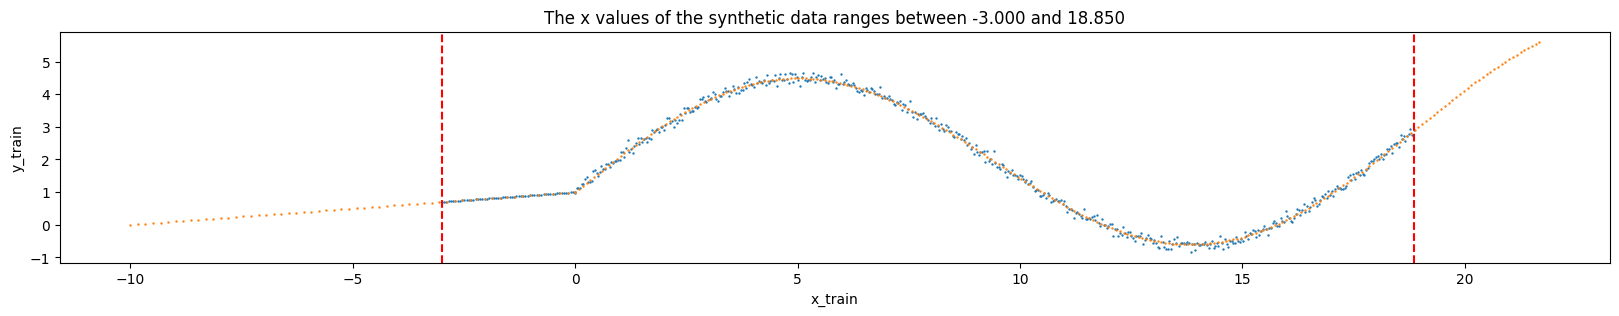

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 256)               512       
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

In [7]:
tfk.backend.clear_session()
if 'nn' in locals():
    del nn
    
# Some network params
'''
Hint: If you set normalize=False the number of neurons per layer should be increased.
'''
#hidden_units=[512,512,512]
hidden_units=[256,256,256]
dropout_rate=0.3
activation='relu'

# Create the dataset
X_train, y_train, X_test, y_test = sinusoid_1(n_train=512,n_test=256, noise=0.1)
#X_train, y_train, X_test, y_test = sinusoid_2(noise=.1)
#X_train, y_train, X_test, y_test = sinusoid_3(noise=.1)

plot_dataset(X_train, y_train, X_test,y_test)

# Create the network
nn = net(X_train=X_train, y_train=y_train,
         n_hidden=hidden_units,
         dropout=dropout_rate,
         activation_fct=activation,
         normalize=True,
         summary=True)

# Train the neural network

Train the neural network. Adust the hyperparameters for training the network

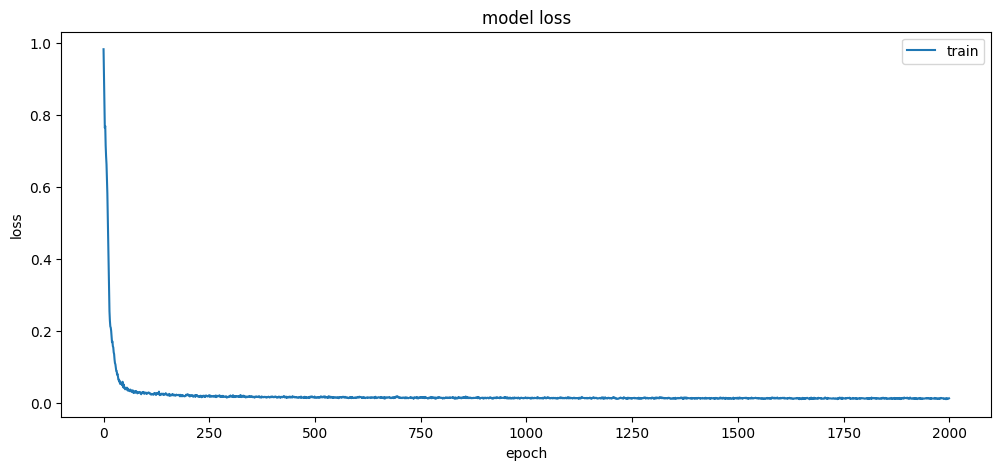

In [8]:
BATCH_SIZE = 256
N_EPOCHS = 2000
history = nn.train(BATCH_SIZE, N_EPOCHS,verbose=0)

if history is not None:
    plt.figure(figsize=(12,5))
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper right')
    #plt.legend(['train', 'valid'], loc='upper right')

# Predict Normal

This is the normal network output without any additional information

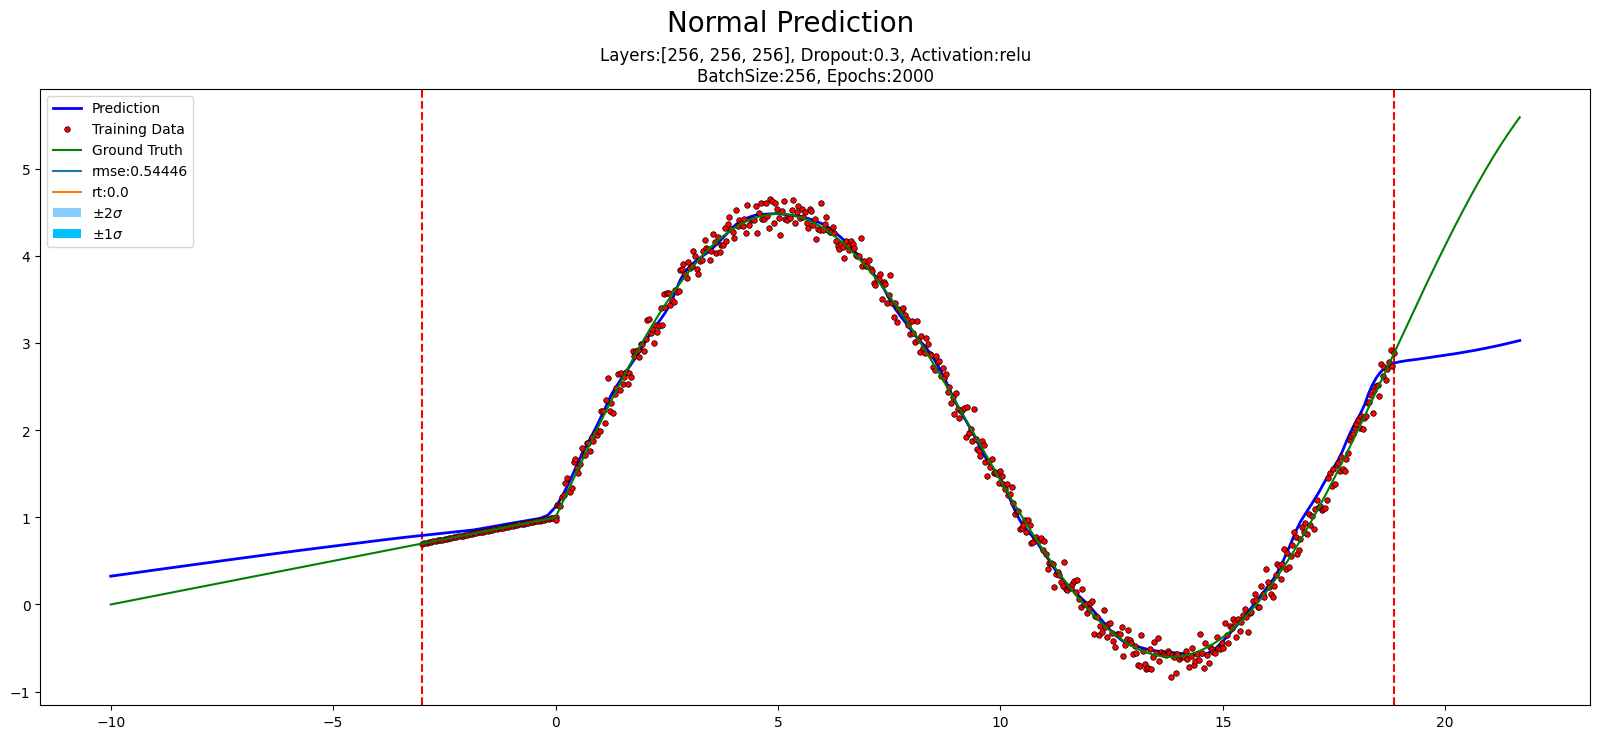

In [9]:
''' Get the prediction, RootMeanSquared Error and Runtime from Normal model'''
normal_pred, normal_std, normal_rmse, _, normal_rt = nn.predict(X_test, y_test)

''' Plot the results'''
plot_predictive_distribution(X_train, y_train,
                             X_test, y_test,
                             normal_pred, normal_std, normal_rmse, None, normal_rt,
                             plot_ground_truth=True,
                             title=f'\n'
                                   f'Layers:{hidden_units}, Dropout:{dropout_rate}, Activation:{activation}\n'
                                   f'BatchSize:{BATCH_SIZE}, Epochs:{N_EPOCHS}')
plt.gcf().suptitle('Normal Prediction', fontsize=20)
plt.show()

# Predict MC Dropout Model

Below you can see the prediction of the MC-Dropout Model. Run the MC-Dropout model a couple of times with different **mc_samples** and check the parameters in the legend. We will see that the **rmse** changes when using the same number of mc_samples. This gives us information about, that the network is not deterministic. The MC-Dropout model is dependend on the forward passes in the network with Dropout enabled.

Further, as all sample based networks, the runtime increases if the number of **mc_samples** increases.

3.222909459028285

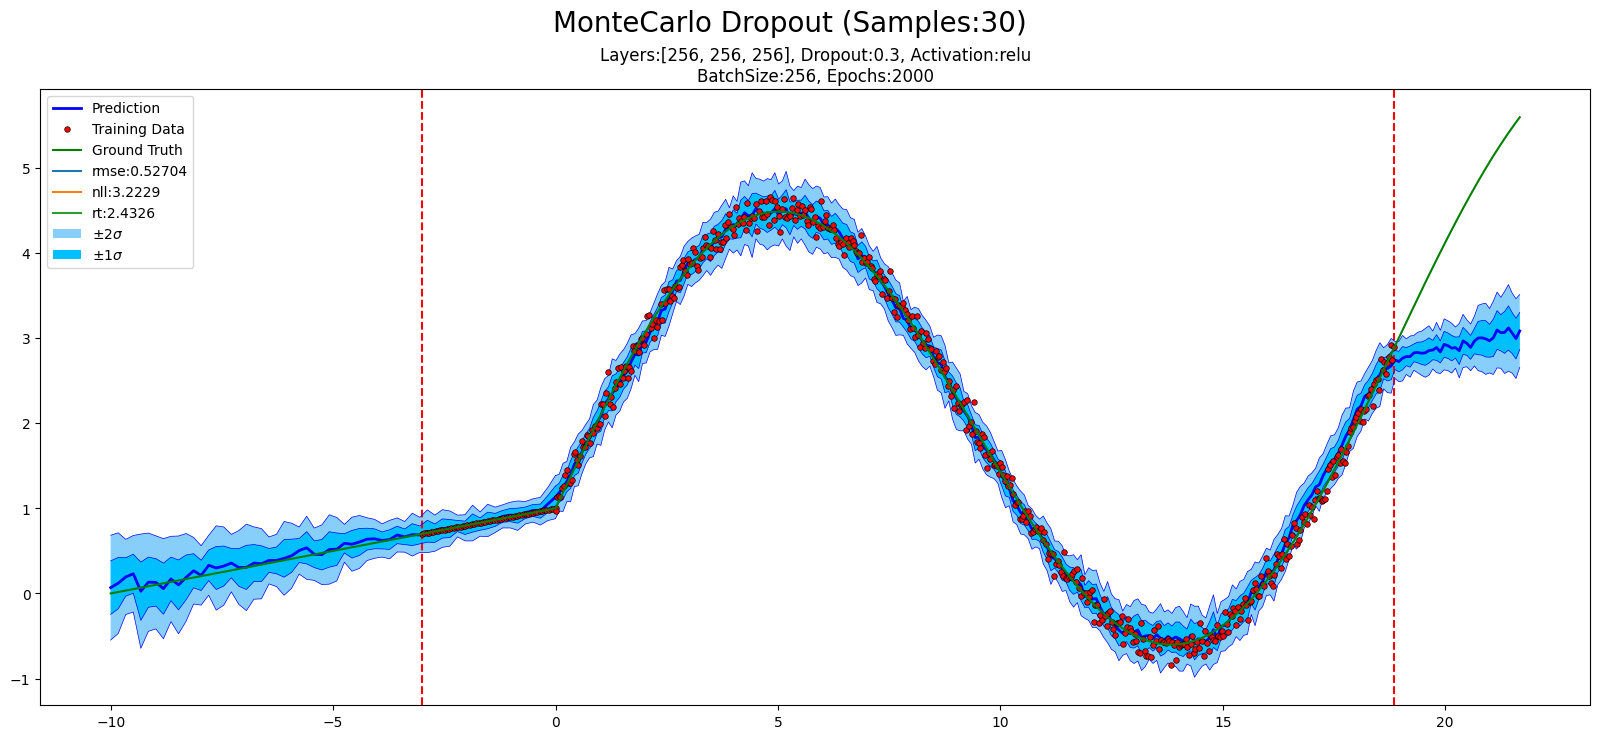

In [10]:
mc_samples = 30

''' Get the prediction, standard deviation, RootMeanSquared Error and Runtime from MC Dropout Model'''
mc_pred, mc_std, mc_rmse, mc_nll, mc_rt = nn.predict_mc(X_test,y_test,mc_samples)

''' Plot the results'''
plot_predictive_distribution(X_train, y_train,
                             X_test, y_test,
                             mc_pred, mc_std, mc_rmse, mc_nll, mc_rt,
                             plot_ground_truth=True,
                             title=f'\n'
                            f'Layers:{hidden_units}, Dropout:{dropout_rate}, Activation:{activation}\n'
                            f'BatchSize:{BATCH_SIZE}, Epochs:{N_EPOCHS}')

plt.gcf().suptitle(f'MonteCarlo Dropout (Samples:{mc_samples})', fontsize=20)
mc_nll

## MC Dropout Samples (Evaluation)

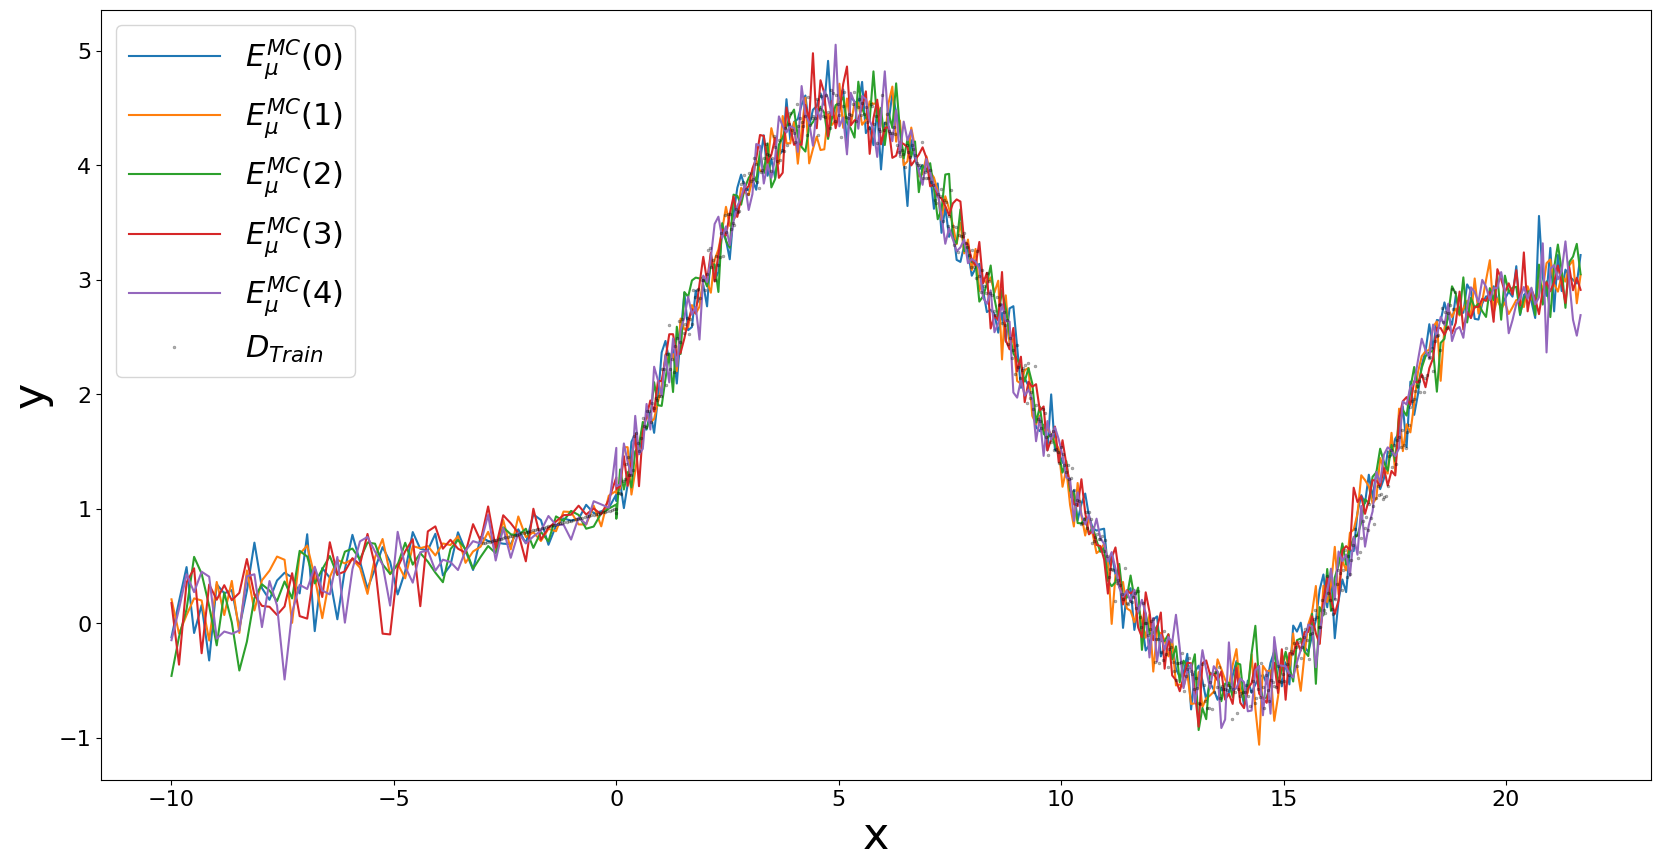

In [11]:
fig, ax = plt.subplots(figsize=(20, 10),nrows=1,ncols=1, sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.2,wspace=0.5)
for i in range(5):
    idx = np.random.choice(nn._mc_means.shape[0],1,replace=False)
    ax.plot(X_test,np.mean(nn._mc_means[idx],0),label=f'$E^{{MC}}_{{\mu}}({i})$')
ax.plot(X_train[:,0], y_train, 'k.', markersize=4,
            markeredgecolor='k',markeredgewidth=0.5, alpha=0.3,label=u'$D_{Train}$')
    #sns.distplot(np.mean(nn._mc_means[idx],0))
ax.set_xlabel('x',fontsize=32)
ax.set_ylabel('y',fontsize=32)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(handlelength=3,prop={'size': 22})
#plt.legend()

# Predict Moment Propagation Model

Compared to the MC-Dropout model, the EP model is deterministic because it does not depend on muliple forward passes. It only depends on a trained network with dropout and does the calulation of the variance (error) based on the Bernoulli distribution of the dropout layers. The calculated error, or variance is propagated through all layers in the trained network.

As you can see in the legend the runtime of the EP-model is less than the MC-Dropout model but higher than the normal model. This is due to the fact that tensorflow creates a big graph for all mathematical operations (one layer per operation). With eager-execution enabled this slows down a bit. Disabling Eager-Execution (**tf.compat.v1.disable_eager_execution()**) you can increase the speed significantly. 

You can enable the cell below to check the Comparison of Normal-Model vs. EP-Model summary. 

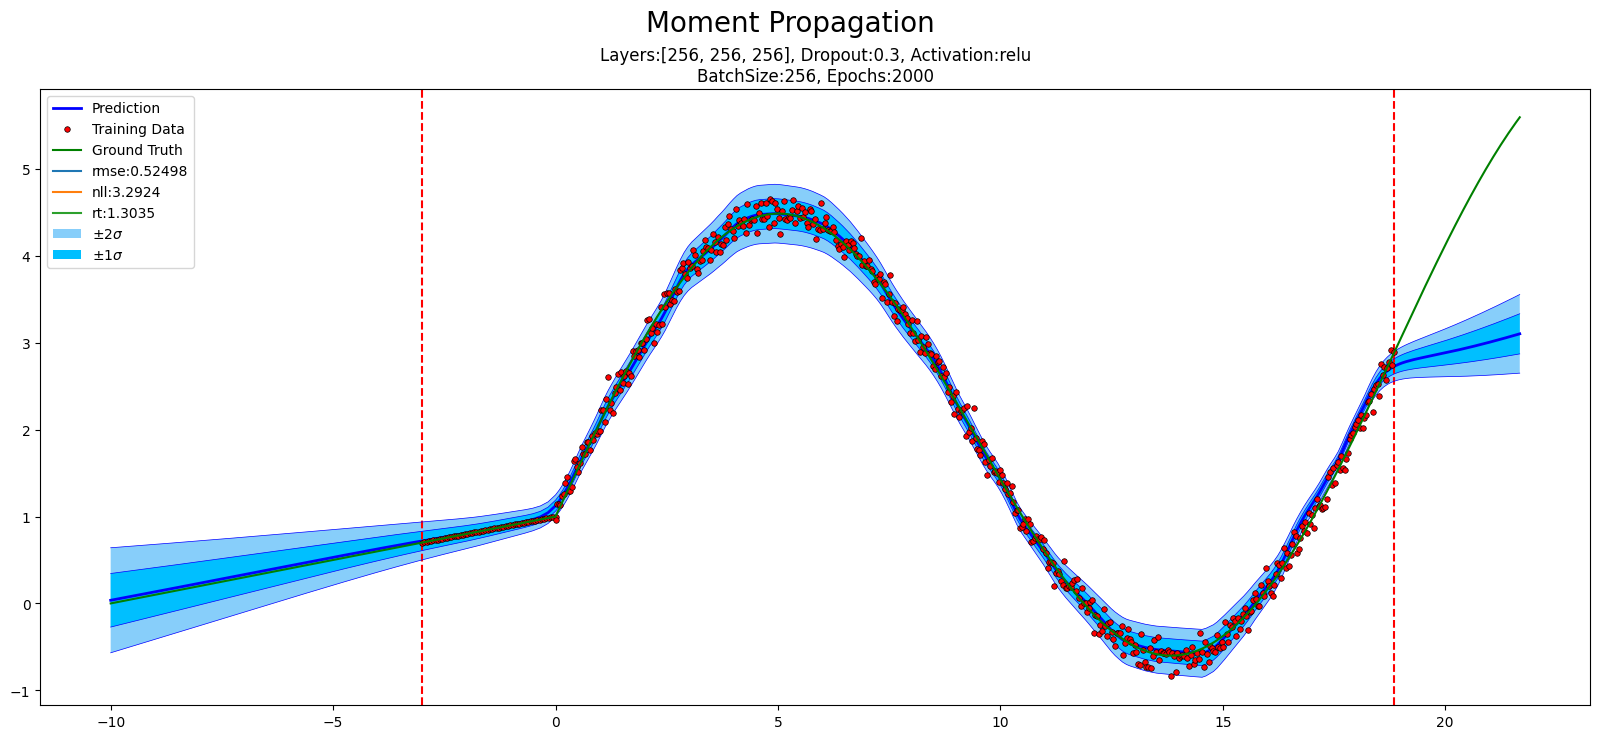

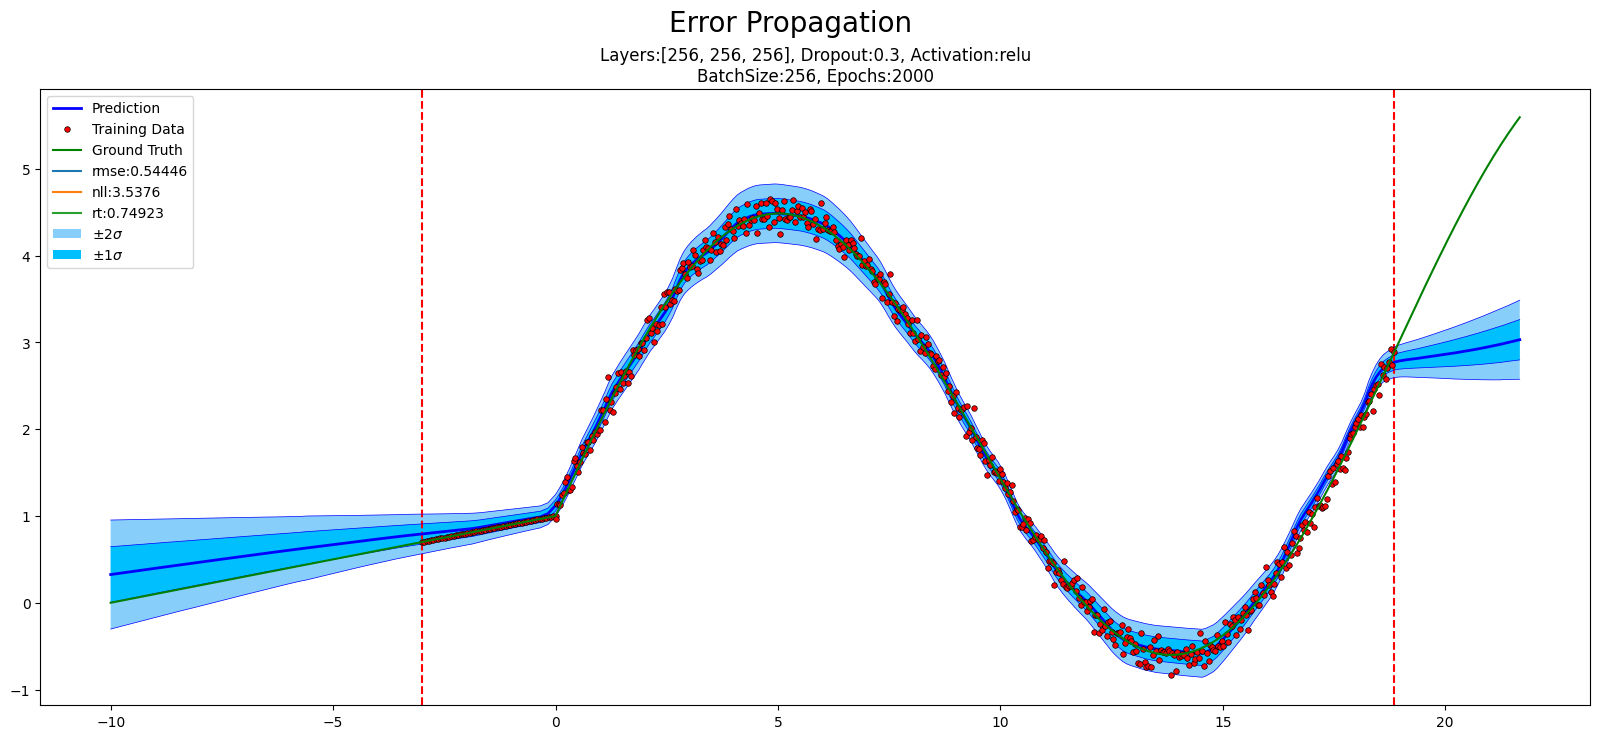

In [12]:
############# Moment Propagation ############# 

''' Get the values from Moment Propagation Model'''
mp_pred, mp_std, mp_rmse, mp_nll, mp_rt = nn.predict_mp(X_test, y_test,use_mp=True, verbose=True)


''' Plot the results'''
plot_predictive_distribution(X_train, y_train, 
                             X_test, y_test,
                             mp_pred, mp_std, mp_rmse, mp_nll, mp_rt,
                             plot_ground_truth=True,
                             title=f'\n'
                            f'Layers:{hidden_units}, Dropout:{dropout_rate}, Activation:{activation}\n'
                            f'BatchSize:{BATCH_SIZE}, Epochs:{N_EPOCHS}'
                            )
plt.gcf().suptitle(f'Moment Propagation', fontsize=20)
plt.show()


# ############# Error Propagation ############# 

# ''' Get the values from Error Propagation Model'''
ep_pred, ep_std, ep_rmse, ep_nll, ep_rt = nn.predict_mp(X_test, y_test, use_mp=False, verbose=True)

''' Plot the results'''
plot_predictive_distribution(X_train, y_train,
                             X_test, y_test,
                             ep_pred, ep_std, ep_rmse, ep_nll, ep_rt,
                             plot_ground_truth=True,
                             title=f'\n'
                            f'Layers:{hidden_units}, Dropout:{dropout_rate}, Activation:{activation}\n'
                            f'BatchSize:{BATCH_SIZE}, Epochs:{N_EPOCHS}')
plt.gcf().suptitle(f'Error Propagation', fontsize=20)
plt.show()

In [13]:
mc_nll, mp_nll, ep_nll

(3.222909459028285, 3.292380229572287, 3.537586721784052)

# ICML Paper Plots

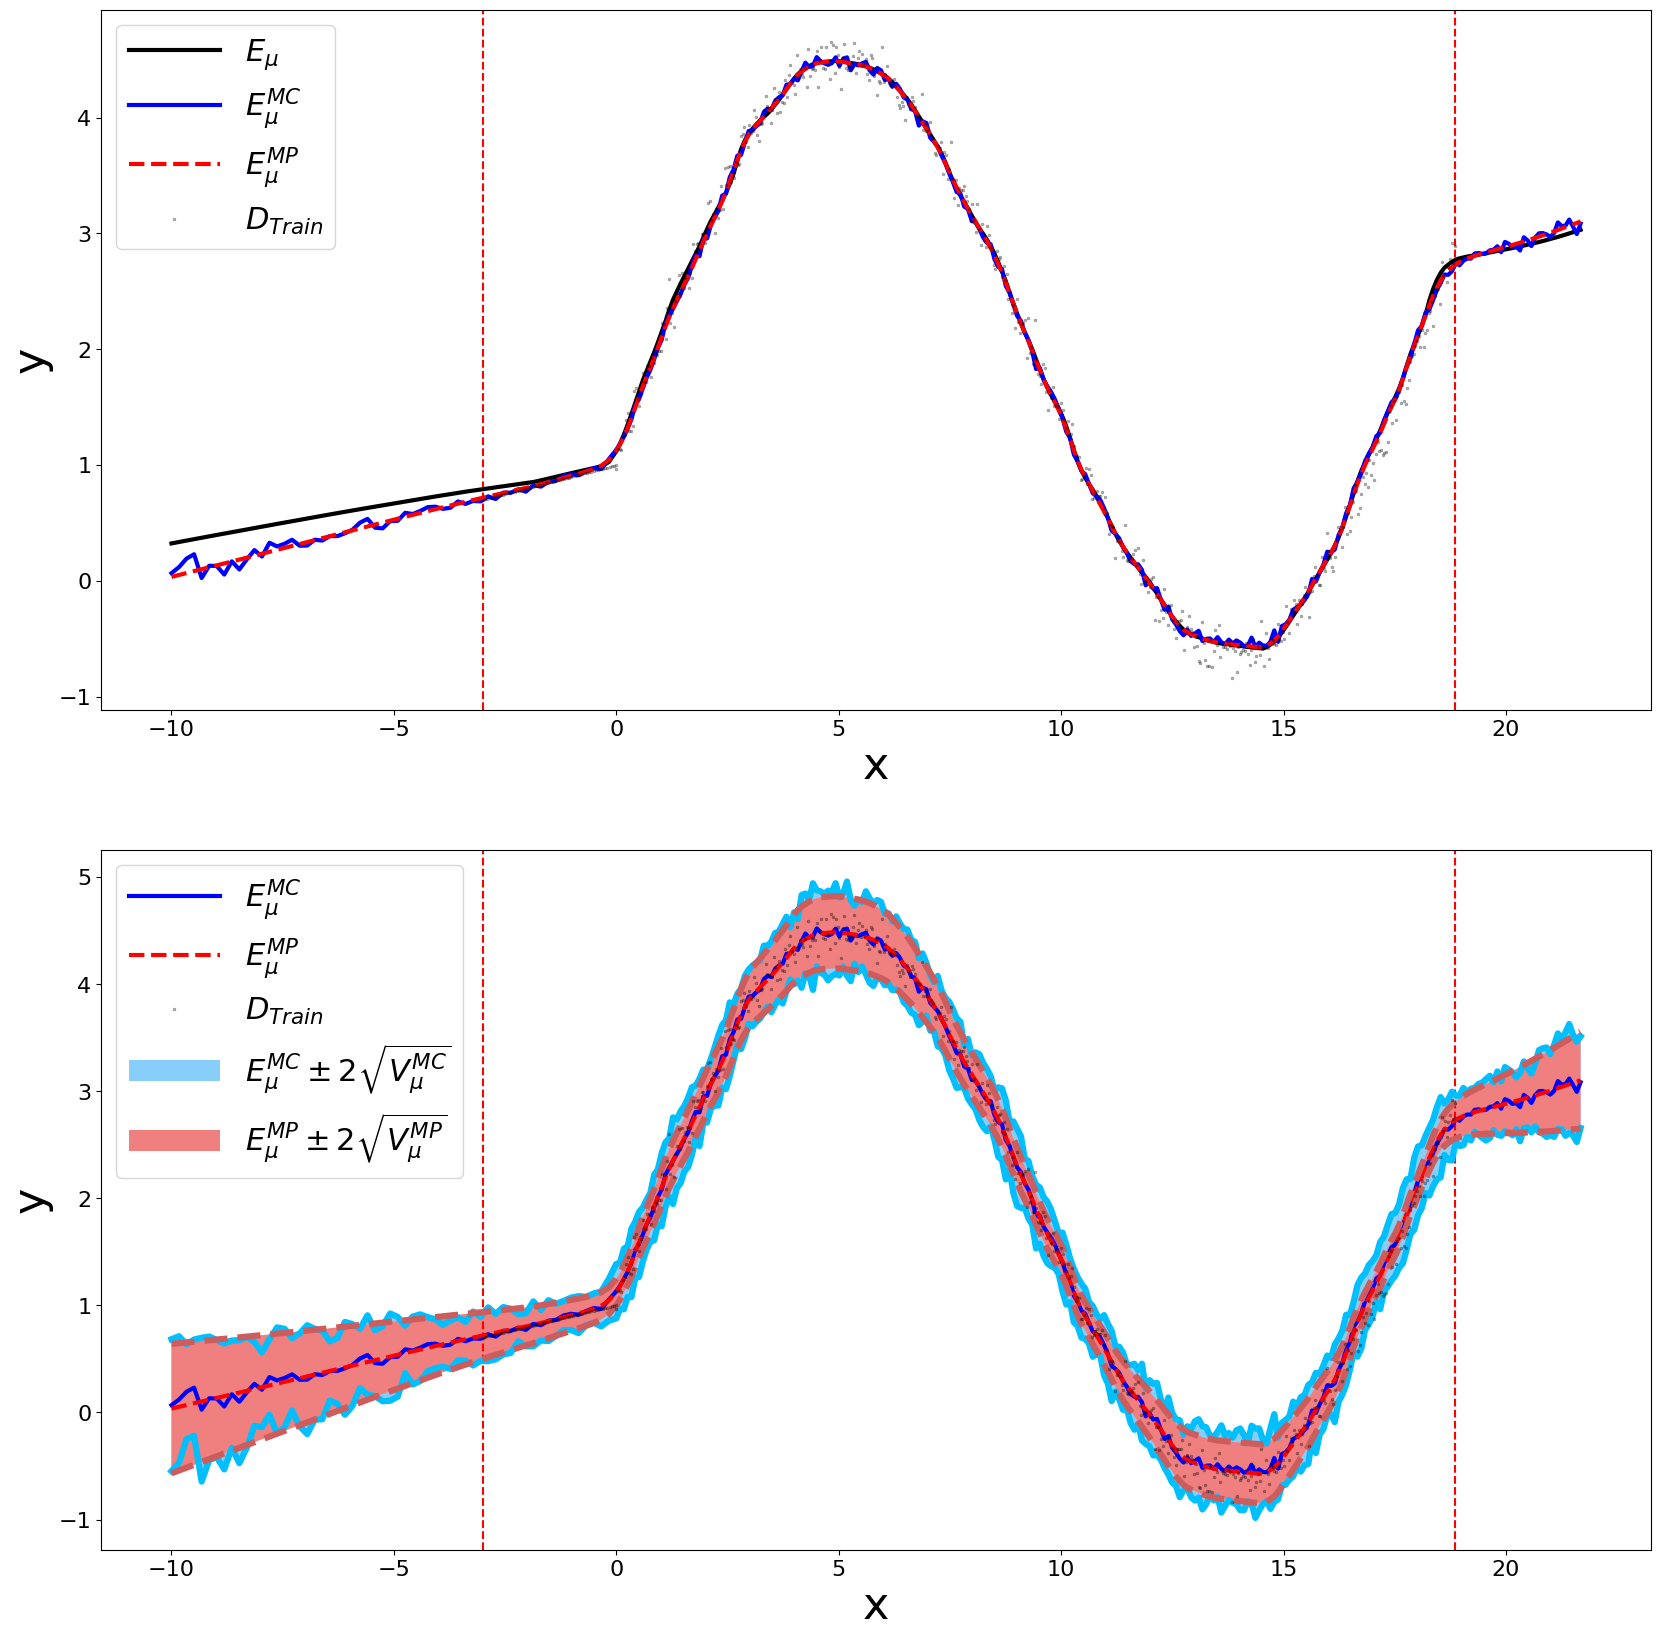

In [14]:
fig, ax = plt.subplots(figsize=(20, 20),nrows=2,ncols=1, sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.2,wspace=0.5)

''' Plot the network predictions (mean)'''
plot_predictions_combined(X_train, y_train,
                          X_test, y_test,
                          mu_normal = normal_pred,
                          mu_mc = mc_pred,
                          mu_mp = mp_pred,
                          plot_ground_truth=False,
                          plot_training_data=True,
                          ax=ax[0],
                          mode=[1,2,3],
                          plot_legend=True
                          #title='$E_{\mu}$ Comparison', ax=None
                          )
''' Plot the network predictions (CI)'''
plot_predictive_distribution_combined(X_train, y_train,
                                      X_test, y_test,
                                      mc_pred, mc_std,
                                      mp_pred, mp_std,
                                      plot_ground_truth=False,
                                      plot_training_data=True,
                                      ax=ax[1],
                                      mode = [1,2],
                                      plot_legend=True
#                                       title=f'\n'
#                                     f'Layers:{hidden_units}, Dropout:{dropout_rate}, Activation:{activation}\n'
#                                     f'BatchSize:{BATCH_SIZE}, Epochs:{N_EPOCHS}, T:{mc_samples}'
                                     
                                     )
plt.savefig("toy.pdf", bbox_inches = 'tight',pad_inches = 0)

## References
* [Propagation of uncertainty](https://en.wikipedia.org/wiki/Propagation_of_uncertainty)
* [The Variance of the product of two independent random variables](http://www.odelama.com/data-analysis/Commonly-Used-Math-Formulas/)
* [Mean and Variance of Linear Combinations](https://online.stat.psu.edu/stat414/book/export/html/779)
* [Recap Taylor Series](https://en.wikipedia.org/wiki/Taylor_series)
* [Recap Taylor Expansion for moments of functions of random variables](https://en.wikipedia.org/wiki/Taylor_expansions_for_the_moments_of_functions_of_random_variables)
* [Taylor Approximation Delta Method](http://www.stat.rice.edu/~dobelman/notes_papers/math/TaylorAppDeltaMethod.pdf)
* [Matrix Calculus Deep Learning](https://explained.ai/matrix-calculus/)
* [The Matrix Calculus You Need For Deep Learning](https://arxiv.org/pdf/1802.01528.pdf)
* Vorlesungsunterlagen Robotik (Extended Kalman-Filter)

